In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler 

In [110]:
df = pd.read_csv('../data/processed/properties.csv')

# Assuming df is your DataFrame
numerical_columns = df.columns.difference(['period'])  # Exclude 'Period'

# Create a StandardScaler
scaler = StandardScaler()  

# Standardize the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Use the interpolate method to fill missing values with interpolation
df = df.interpolate()

# Sort the DataFrame by the 'period' column
df = df.sort_values(by='period')

df

,period,num_nodes,num_edges,density,avg_clustering,assortativity,avg_shortest_path
0,2000M01,-1.947821,-1.448398,-1.414800,-2.189090,-1.259842,-1.018583
1,2000M02,-1.527660,-1.407006,-1.627588,-2.567136,-1.201641,-0.817933
2,2000M03,-1.656940,-1.395717,-1.466600,-1.322957,-1.220972,-0.617283
3,2000M04,-1.656940,-1.399480,-1.482401,-0.880277,-1.406542,-0.521313
4,2000M05,-1.753900,-1.393208,-1.359877,-1.129810,-0.920837,-1.653585
...,...,...,...,...,...,...,...
280,2023M05,0.960982,0.830711,0.638994,0.813064,0.110855,-0.769097
281,2023M06,0.960982,0.767995,0.546720,1.035085,-0.004212,-0.500082
282,2023M07,0.767062,0.663886,0.625349,0.366248,-0.044437,-0.589960
283,2023M08,0.670102,0.612459,0.666572,1.194386,0.029263,-0.557070


### Uncertainty for each property

In [111]:

# Function to calculate mean squared errors for each column over h-periods
def calculate_mse_df(df, h):
    # Sort the DataFrame by the 'period' column
    df = df.sort_values(by='period')
    
    # Create an empty DataFrame to store mean squared errors for each column
    mse_df = pd.DataFrame({'period': df['period'].iloc[h:]})

    # Calculate mean squared error for each column (except 'period') over h-periods
    for column in df.columns[1:]:  # Exclude the 'period' column
        mse_mean_list = []
        avg_uncertainty_list = []
        for i in range(h, len(df)):
            squared_errors = (df[column].iloc[i - h:i] - df[column].iloc[i]) ** 2
            mse_mean = squared_errors.mean()
            mse_mean_list.append(mse_mean)

        # Add the mean squared errors for the column to mse_df
        mse_df[column] = mse_mean_list

    return mse_df

# Function to calculate 'avg_uncertainty' and 'weighted_uncertainty' for each row in mse_df
def calculate_uncertainty_metrics(mse_df):
    # Calculate 'avg_uncertainty' (average of the sum of the other columns)
    mse_df['avg_uncertainty'] = mse_df.iloc[:, 1:7].sum(axis=1) / 6  # Sum of (num_nodes, num_edges, density, avg_clustering, assortativity, avg_shortest_path)

    # Calculate the variance of each column in mse_df
    variances = mse_df.iloc[:, 1:7].var()

    # Calculate 'weighted_uncertainty' (weighted average of the sum of the other columns)
    mse_df['weighted_uncertainty'] = (mse_df.iloc[:, 1:7] * variances).sum(axis=1) / variances.sum()
    
    uncertainties = mse_df[['period','avg_uncertainty', 'weighted_uncertainty']]
    
    return uncertainties

In [112]:
# Specify the values of h
h_values = [1, 3, 6]

# Generate mse_df DataFrames for different values of h
mse_df_1, mse_df_2, mse_df_3 = [calculate_mse_df(df, h) for h in h_values]

# Calculate 'avg_uncertainty' and 'weighted_uncertainty' for each row in mse_df
uncertainties_1 = calculate_uncertainty_metrics(mse_df_1)
uncertainties_2 = calculate_uncertainty_metrics(mse_df_2)
uncertainties_3 = calculate_uncertainty_metrics(mse_df_3)

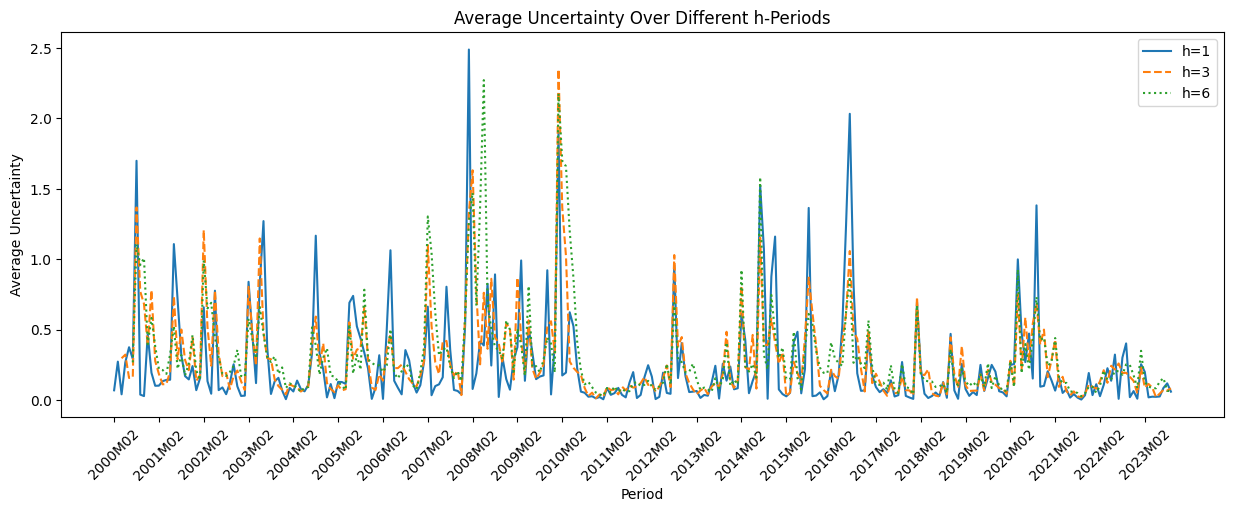

In [115]:
# Plot 'avg_uncertainty'
plt.figure(figsize=(15, 5))
plt.plot(uncertainties_1['period'], uncertainties_1['avg_uncertainty'], label='h=1', linestyle='-')
plt.plot(uncertainties_2['period'], uncertainties_2['avg_uncertainty'], label='h=3', linestyle='--')
plt.plot(uncertainties_3['period'], uncertainties_3['avg_uncertainty'], label='h=6', linestyle=':')


plt.title('Average Uncertainty Over Different h-Periods')
plt.xlabel('Period')
plt.ylabel('Average Uncertainty')
plt.legend()

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(uncertainties_1['period'][::12], rotation=45)
plt.show()



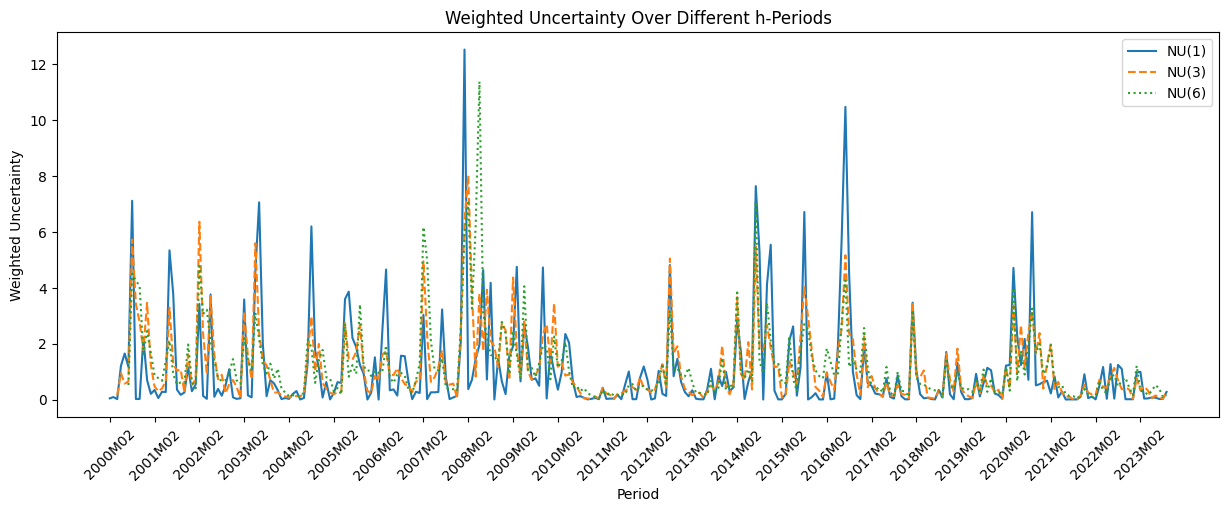

In [117]:

# Plot 'weighted_uncertainty'
plt.figure(figsize=(15, 5))
plt.plot(uncertainties_1['period'], uncertainties_1['weighted_uncertainty'], label='NU(1)', linestyle='-')
plt.plot(uncertainties_2['period'], uncertainties_2['weighted_uncertainty'], label='NU(3)', linestyle='--')
plt.plot(uncertainties_3['period'], uncertainties_3['weighted_uncertainty'], label='NU(6)', linestyle=':')
    
plt.title('Weighted Uncertainty Over Different h-Periods')
plt.xlabel('Period')
plt.ylabel('Weighted Uncertainty')
plt.legend()

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(uncertainties_1['period'][::12], rotation=45)
plt.show()